# Pathfinding Algorithm Comparison Analysis

This notebook provides a comprehensive statistical analysis and visualization of different pathfinding algorithms (A*, Dijkstra, Breadth-First, Theta*) across various test cases with different start-to-end distances.


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set figure size for better visibility
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Define consistent color mapping for algorithms
ALGORITHM_COLORS = {
    'A*': '#1f77b4',           # Blue
    'Dijkstra': '#ff7f0e',     # Orange
    'Breadth-First': '#2ca02c', # Green
    'Theta*': '#d62728'        # Red
}

# Create color list for easy access
algorithm_color_list = [ALGORITHM_COLORS[algo] for algo in ['A*', 'Dijkstra', 'Breadth-First', 'Theta*']]

# Create output directory for saving plots
output_dir = f"algorithm_analysis_plots_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")
else:
    print(f"Using existing output directory: {output_dir}")

# Function to save plots
def save_plot(filename, dpi=300, bbox_inches='tight'):
    """Save the current plot to the output directory"""
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches, facecolor='white', edgecolor='none')
    print(f"Saved: {filepath}")
    return filepath


Created output directory: algorithm_analysis_plots_20250917_203417


## Data Loading and Preprocessing


In [59]:
# Load the data
try:
    df = pd.read_csv('pathfinding_comparison_results.csv')
except FileNotFoundError:
    print("Results file not found. Running algorithm comparison first...")
    import subprocess
    subprocess.run(['python', 'algorithm_comparison.py'])
    df = pd.read_csv('pathfinding_comparison_results.csv')

# Normalize dtypes to match comparison CSV schema
if 'success' in df.columns and df['success'].dtype != bool:
    df['success'] = df['success'].astype(str).str.lower().map({'true': True, 'false': False, '1': True, '0': False}).fillna(False).astype(bool)
# Ensure numeric dtypes for key columns
for col in ['length', 'execution_time', 'operations', 'path_length', 'direct_distance']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
# Provide backward-compat euclidean_distance alias if CSV uses direct_distance
if 'euclidean_distance' not in df.columns and 'direct_distance' in df.columns:
    df['euclidean_distance'] = df['direct_distance']
# Normalized metric: execution time per unit length (seconds per Z unit)
df['time_per_length'] = df['execution_time'] / df['length'].replace(0, np.nan)
# Compute path_efficiency if not provided: direct_distance / path_length (only for successful runs)
if 'path_efficiency' not in df.columns:
    df['path_efficiency'] = np.where((df.get('path_length', 0) > 0) & df.get('success', False),
                                    df.get('direct_distance', 0) / df.get('path_length', 1), 0.0)

# Outlier filtering: use IQR on path_efficiency only (per algorithm × distance_category)
if 'path_efficiency' in df.columns:
    grp = []
    if 'algorithm' in df.columns:
        grp.append('algorithm')
    if 'distance_category' in df.columns:
        grp.append('distance_category')
    if grp:
        q1 = df.groupby(grp)['path_efficiency'].transform(lambda x: x.quantile(0.25))
        q3 = df.groupby(grp)['path_efficiency'].transform(lambda x: x.quantile(0.75))
    else:
        q1 = pd.Series(df['path_efficiency'].quantile(0.25), index=df.index)
        q3 = pd.Series(df['path_efficiency'].quantile(0.75), index=df.index)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    keep_pf = (df['path_efficiency'].isna()) | ((df['path_efficiency'] >= low) & (df['path_efficiency'] <= high))
    before_pf = len(df)
    df = df[keep_pf].copy()
    print(f"Outlier filtering on path_efficiency (IQR): removed {before_pf - len(df)} rows")
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

print("\n" + "="*60)
print("IMPORTANT DISTINCTION:")
print("="*60)
print("• direct_distance: Straight-line distance between start and end coordinates")
print("• path_length: Actual distance of the path found by the algorithm")
print("• path_efficiency: direct_distance / path_length (higher is better; 1.0 is optimal)")
print("• time_per_length: execution_time divided by length (seconds per unit length)")
print("="*60)


Outlier filtering on path_efficiency (IQR): removed 78 rows
Dataset Shape: (1522, 12)

Column Names:
['distance_category', 'length', 'seed', 'algorithm', 'direct_distance', 'execution_time', 'operations', 'success', 'path_length', 'euclidean_distance', 'time_per_length', 'path_efficiency']

First few rows:
  distance_category  length    seed      algorithm  direct_distance  \
0             10-50      50  500000             A*          22.7596   
1             10-50      50  500000       Dijkstra          22.7596   
2             10-50      50  500000  Breadth-First          22.7596   
3             10-50      50  500000         Theta*          22.7596   
4             10-50      50  500001             A*          18.5472   

   execution_time  operations  success  path_length  euclidean_distance  \
0        0.001674          82     True      23.8489             22.7596   
1        0.211805       16008     True      23.8489             22.7596   
2        0.067727        9939     True  

In [60]:
# Ensure distance_category column (prefer CSV's own if present)
if 'distance_category' not in df.columns:
    def categorize_by_length(L):
        try:
            L = int(L)
        except Exception:
            return 'Other'
        return {10: 'Short', 100: 'Medium', 200: 'Long', 300: 'Very Long'}.get(L, 'Other')
    df['distance_category'] = df['length'].apply(categorize_by_length)

# Display the distribution of distance categories
print("Distance Category Distribution (from CSV distance_category):")
print(df['distance_category'].value_counts())
print("\nDistance Category by Algorithm:")
print(pd.crosstab(df['algorithm'], df['distance_category']))

print("\n" + "="*60)
print("DISTANCE CATEGORY EXPLANATION (by length):")
print("="*60)
print("• Short: length = 10")
print("• Medium: length = 100") 
print("• Long: length = 200")
print("• Very Long: length = 300")
print("Note: Categories map directly to maze length.")
print("="*60)


Distance Category Distribution (from CSV distance_category):
distance_category
100-200    389
200-300    388
50-100     383
10-50      362
Name: count, dtype: int64

Distance Category by Algorithm:
distance_category  10-50  100-200  200-300  50-100
algorithm                                         
A*                    89       96       97      95
Breadth-First         95       99       98      97
Dijkstra              89       96       97      95
Theta*                89       98       96      96

DISTANCE CATEGORY EXPLANATION (by length):
• Short: length = 10
• Medium: length = 100
• Long: length = 200
• Very Long: length = 300
Note: Categories map directly to maze length.


## Basic Statistical Analysis


In [61]:
# Calculate comprehensive statistics for each algorithm
metrics = ['time_per_length', 'operations', 'path_length', 'path_efficiency']

print("=== COMPREHENSIVE STATISTICAL ANALYSIS ===\n")

for metric in metrics:
    print(f"\n{'='*50}")
    print(f"ANALYSIS FOR: {metric.upper()}")
    print(f"{'='*50}")
    
    # Overall statistics
    stats_data = df.groupby('algorithm')[metric].agg([
        'count', 'mean', 'median', 'std', 'var', 'min', 'max',
        ('mode', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
        ('q25', lambda x: x.quantile(0.25)),
        ('q75', lambda x: x.quantile(0.75)),
        ('iqr', lambda x: x.quantile(0.75) - x.quantile(0.25))
    ]).round(4)
    
    print("\nOverall Statistics by Algorithm:")
    print(stats_data)
    
    # Coefficient of variation (CV = std/mean)
    stats_data['cv'] = (stats_data['std'] / stats_data['mean'] * 100).round(2)
    print("\nCoefficient of Variation (%):")
    print(stats_data[['mean', 'std', 'cv']])
    
    # Distance category analysis
    print("\nStatistics by Distance Category:")
    distance_stats = df.groupby(['algorithm', 'distance_category'])[metric].agg([
        'mean', 'median', 'std', 'count'
    ]).round(4)
    print(distance_stats)


=== COMPREHENSIVE STATISTICAL ANALYSIS ===


ANALYSIS FOR: TIME_PER_LENGTH

Overall Statistics by Algorithm:
               count    mean  median     std     var     min     max    mode  \
algorithm                                                                      
A*               377  0.0017  0.0005  0.0024  0.0000  0.0000  0.0155  0.0000   
Breadth-First    389  0.0091  0.0103  0.0038  0.0000  0.0004  0.0147  0.0004   
Dijkstra         377  0.0184  0.0208  0.0074  0.0001  0.0006  0.0356  0.0006   
Theta*           379  0.0039  0.0007  0.0061  0.0000  0.0000  0.0389  0.0002   

                  q25     q75     iqr  
algorithm                              
A*             0.0001  0.0026  0.0025  
Breadth-First  0.0074  0.0123  0.0050  
Dijkstra       0.0148  0.0244  0.0095  
Theta*         0.0002  0.0059  0.0057  

Coefficient of Variation (%):
                 mean     std      cv
algorithm                            
A*             0.0017  0.0024  141.18
Breadth-First  0.0091  0.

## Distribution Analysis and Visualizations


In [62]:
# Sanity check: summarize time-per-length per algorithm and length
print('Time per Length (s/unit) — summary by algorithm and length')
tpl_summary = (
    df.groupby(['algorithm','length'])['time_per_length']
      .agg(['count','mean','median','std']).round(6)
)
print(tpl_summary)


Time per Length (s/unit) — summary by algorithm and length
                      count      mean    median       std
algorithm     length                                     
A*            50         89  0.000155  0.000052  0.000266
              100        95  0.000543  0.000204  0.000790
              200        96  0.001689  0.000898  0.002198
              300        97  0.004249  0.003857  0.002776
Breadth-First 50         95  0.003839  0.003183  0.003121
              100        97  0.009334  0.009235  0.001855
              200        99  0.010787  0.011203  0.001713
              300        98  0.012369  0.012487  0.000685
Dijkstra      50         89  0.007818  0.006708  0.006054
              100        95  0.018882  0.018913  0.003623
              200        96  0.021418  0.022161  0.003430
              300        97  0.024554  0.024691  0.001778
Theta*        50         89  0.000327  0.000199  0.000661
              100        96  0.000883  0.000283  0.001647
             

Saved: algorithm_analysis_plots_20250917_203417/03_cdf_time_per_length_astar_theta.png


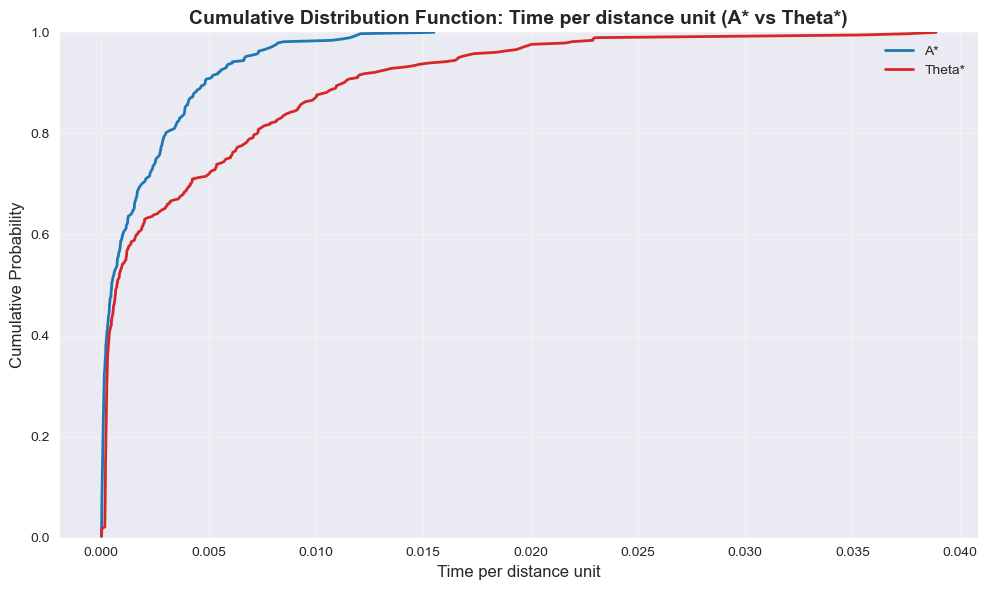

Saved: algorithm_analysis_plots_20250917_203417/03_cdf_time_per_length_bfs_dijkstra.png


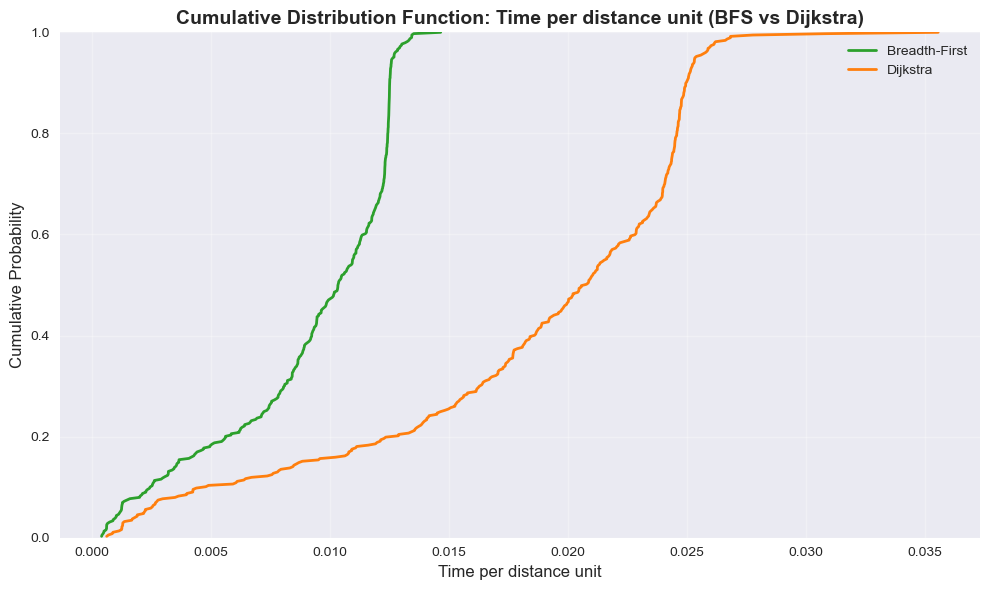

Saved: algorithm_analysis_plots_20250917_203417/03_cdf_operations_astar_theta.png


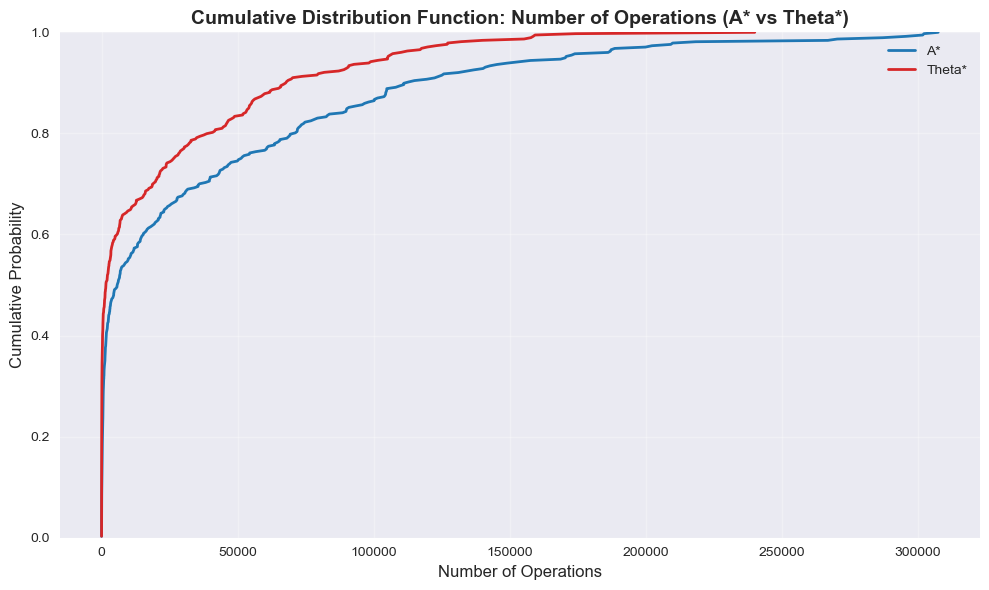

Saved: algorithm_analysis_plots_20250917_203417/03_cdf_operations_bfs_dijkstra.png


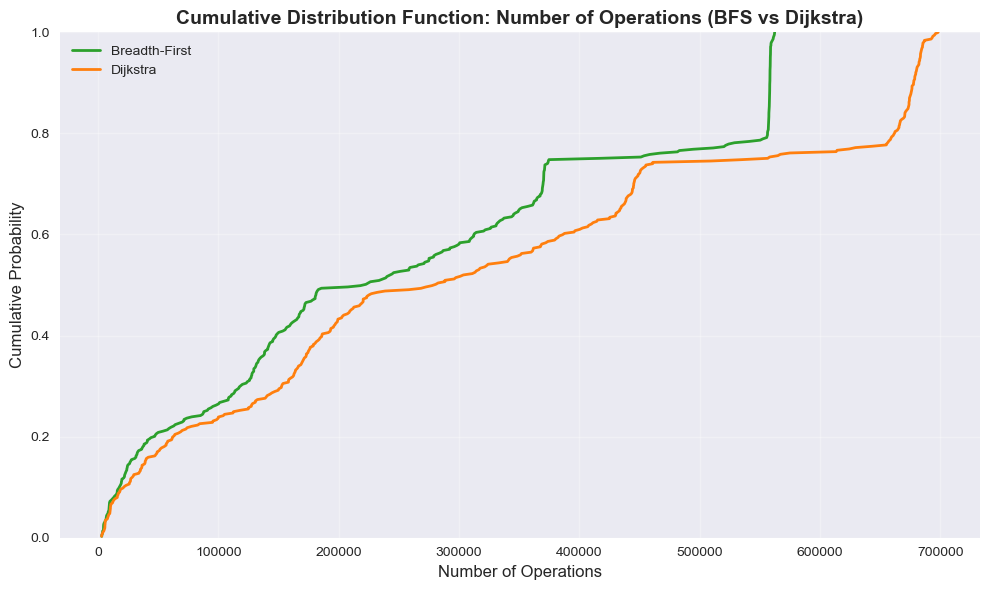

Saved: algorithm_analysis_plots_20250917_203417/03_cdf_path_length.png


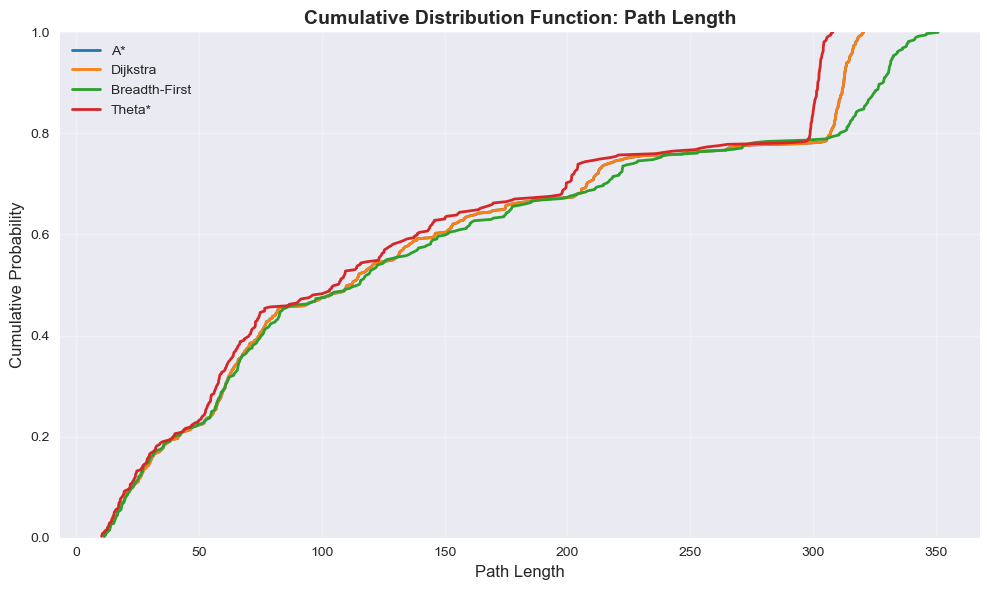

Saved: algorithm_analysis_plots_20250917_203417/03_cdf_path_efficiency.png


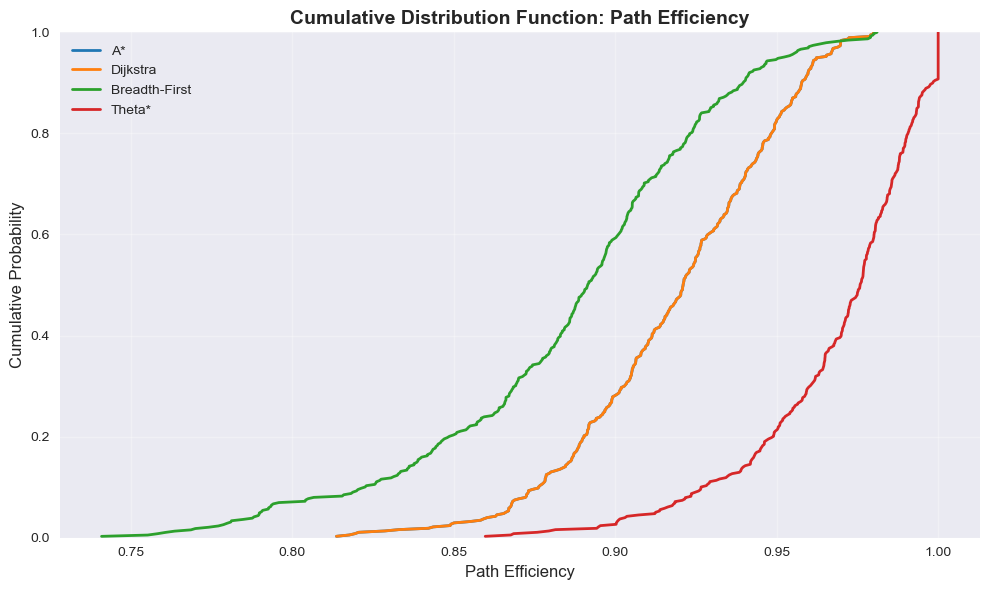

In [63]:
# Create individual Cumulative Distribution Functions (CDFs) for each metric
# For execution_time and operations, create separate plots for A*/Theta* and BFS/Dijkstra
time_ops_metrics = ['time_per_length', 'operations']
time_ops_titles = ['Time per distance unit', 'Number of Operations']

# Create CDFs for execution_time and operations with algorithm groups
for metric, title in zip(time_ops_metrics, time_ops_titles):
    # Plot 1: A* and Theta*
    plt.figure(figsize=(10, 6))
    
    for algorithm in ['A*', 'Theta*']:
        data = df[df['algorithm'] == algorithm][metric].sort_values()
        y = np.arange(1, len(data) + 1) / len(data)
        plt.plot(data, y, label=algorithm, linewidth=2, color=ALGORITHM_COLORS[algorithm])
    
    plt.title(f'Cumulative Distribution Function: {title} (A* vs Theta*)', fontsize=14, fontweight='bold')
    plt.xlabel(title, fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Save the plot
    filename = f"03_cdf_{metric}_astar_theta.png"
    save_plot(filename)
    plt.show()
    
    # Plot 2: BFS and Dijkstra
    plt.figure(figsize=(10, 6))
    
    for algorithm in ['Breadth-First', 'Dijkstra']:
        data = df[df['algorithm'] == algorithm][metric].sort_values()
        y = np.arange(1, len(data) + 1) / len(data)
        plt.plot(data, y, label=algorithm, linewidth=2, color=ALGORITHM_COLORS[algorithm])
    
    plt.title(f'Cumulative Distribution Function: {title} (BFS vs Dijkstra)', fontsize=14, fontweight='bold')
    plt.xlabel(title, fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Save the plot
    filename = f"03_cdf_{metric}_bfs_dijkstra.png"
    save_plot(filename)
    plt.show()

# Create CDFs for path_length and path_efficiency (all algorithms together)
other_metrics = ['path_length', 'path_efficiency']
other_titles = ['Path Length', 'Path Efficiency']

for metric, title in zip(other_metrics, other_titles):
    plt.figure(figsize=(10, 6))
    
    for algorithm in df['algorithm'].unique():
        data = df[df['algorithm'] == algorithm][metric].sort_values()
        y = np.arange(1, len(data) + 1) / len(data)
        plt.plot(data, y, label=algorithm, linewidth=2, color=ALGORITHM_COLORS[algorithm])
    
    plt.title(f'Cumulative Distribution Function: {title}', fontsize=14, fontweight='bold')
    plt.xlabel(title, fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Save the plot
    filename = f"03_cdf_{metric}.png"
    save_plot(filename)
    plt.show()


Saved: algorithm_analysis_plots_20250917_203417/03_violin_time_per_length.png


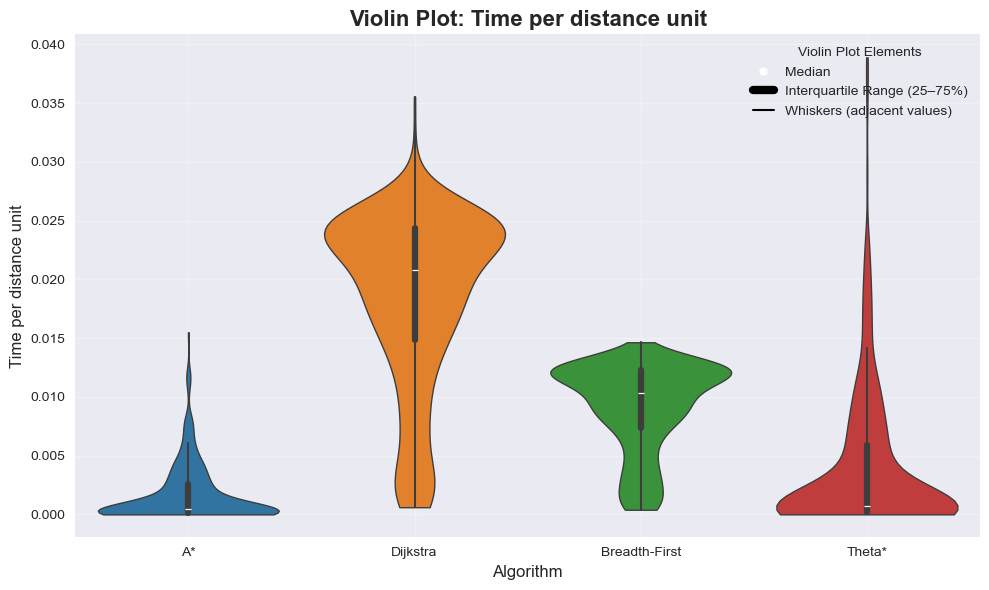

Saved: algorithm_analysis_plots_20250917_203417/03_violin_operations.png


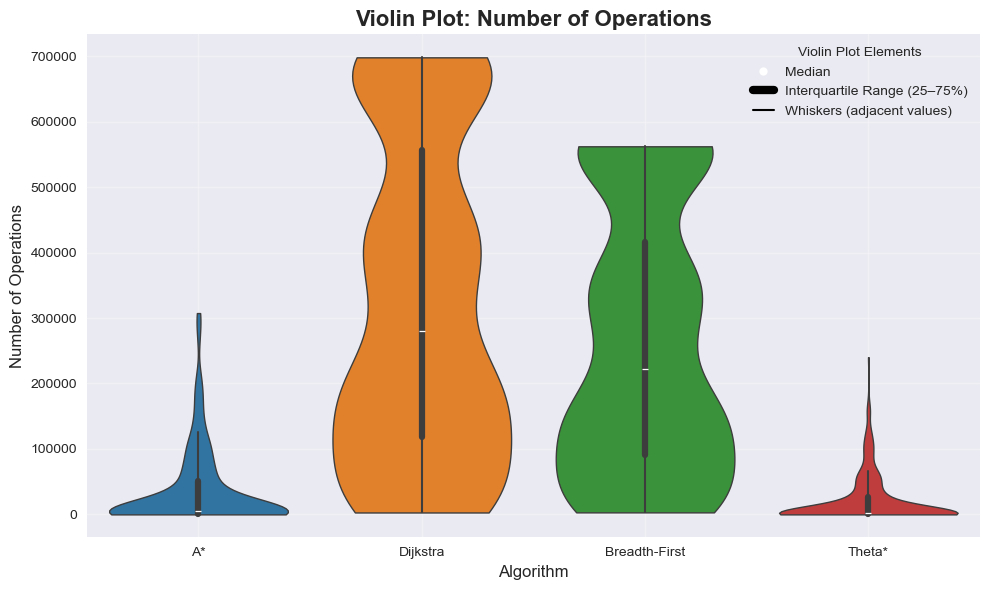

Saved: algorithm_analysis_plots_20250917_203417/03_violin_path_length.png


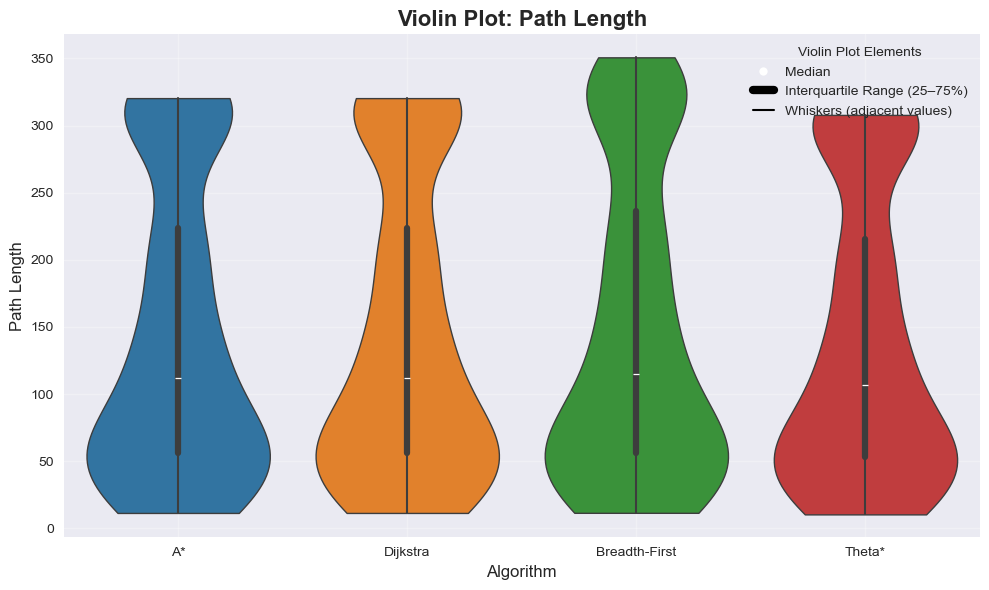

Saved: algorithm_analysis_plots_20250917_203417/03_violin_path_efficiency.png


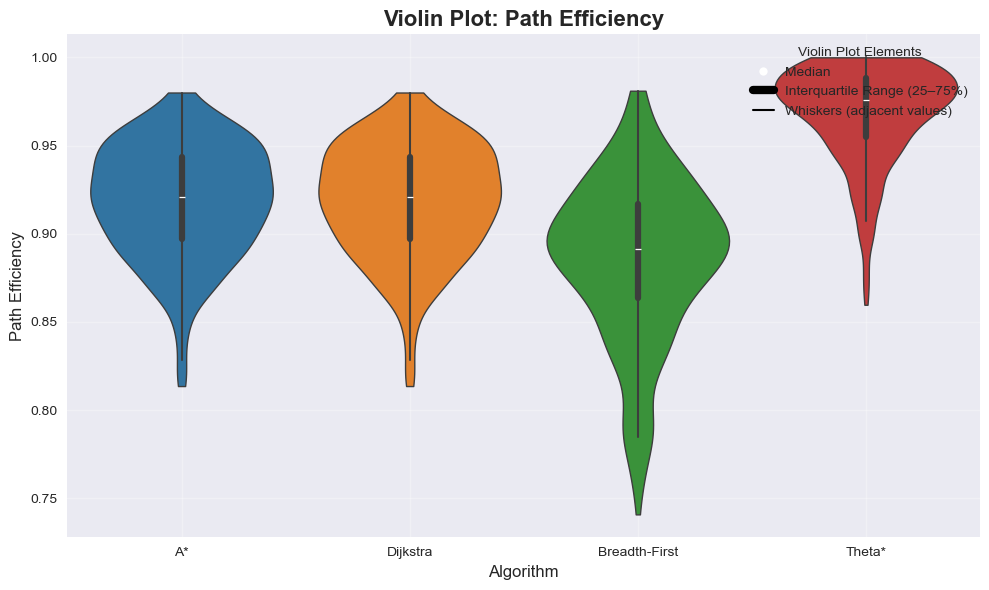

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Define metrics and titles for plotting
metrics = ['execution_time', 'operations', 'path_length', 'path_efficiency']
titles = ['Execution Time (seconds)', 'Number of Operations', 'Path Length', 'Path Efficiency']

# Define metrics and titles locally so this cell works standalone
metrics = ['time_per_length', 'operations', 'path_length', 'path_efficiency']
titles = ['Time per distance unit', 'Number of Operations', 'Path Length', 'Path Efficiency']

for metric, title in zip(metrics, titles):
    plt.figure(figsize=(10, 6))

    sns.violinplot(
        data=df,
        x="algorithm",
        y=metric,
        inner="box",       # show median & quartiles inside
        cut=0,
        scale="width",
        linewidth=1,
        palette=ALGORITHM_COLORS
    )

    plt.title(f'Violin Plot: {title}', fontsize=16, fontweight='bold')
    plt.xlabel("Algorithm", fontsize=12)
    plt.ylabel(title, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # --- Custom legend for inner="box" ---
    median = Line2D([], [], linestyle='None', marker='o',
                    markersize=6, markerfacecolor='white', markeredgecolor='black',
                    label='Median')

    iqr = Line2D([], [], color="black", linewidth=6,
                 label='Interquartile Range (25–75%)')

    whiskers = Line2D([], [], color="black", linewidth=1.5,
                      label='Whiskers (adjacent values)')

    plt.legend(
        handles=[median, iqr, whiskers],
        title="Violin Plot Elements",
        loc="upper right",
        fontsize=10,
        handlelength=1.5
    )

    filename = f"03_violin_{metric}.png"
    save_plot(filename)
    plt.show()

## Analysis by Distance Categories


Saved: algorithm_analysis_plots_20250917_203417/04_distance_category_execution_time.png


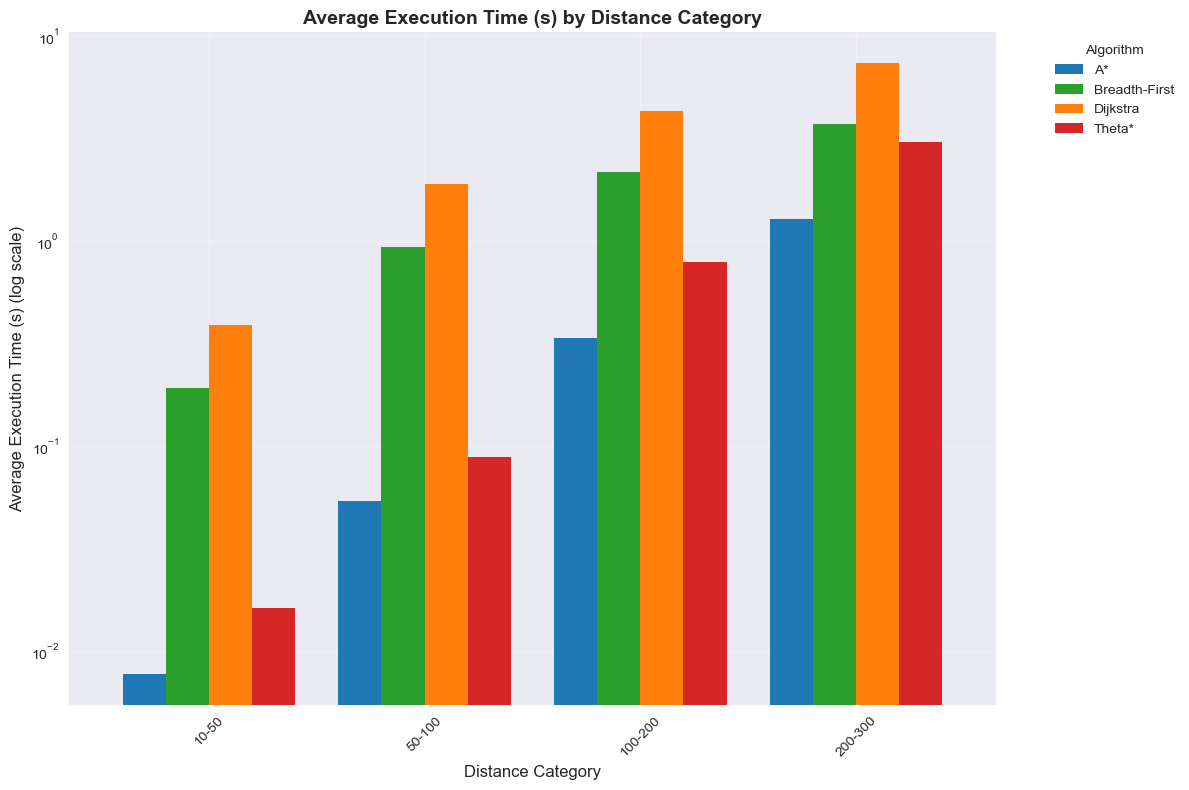

Saved: algorithm_analysis_plots_20250917_203417/04_distance_category_operations.png


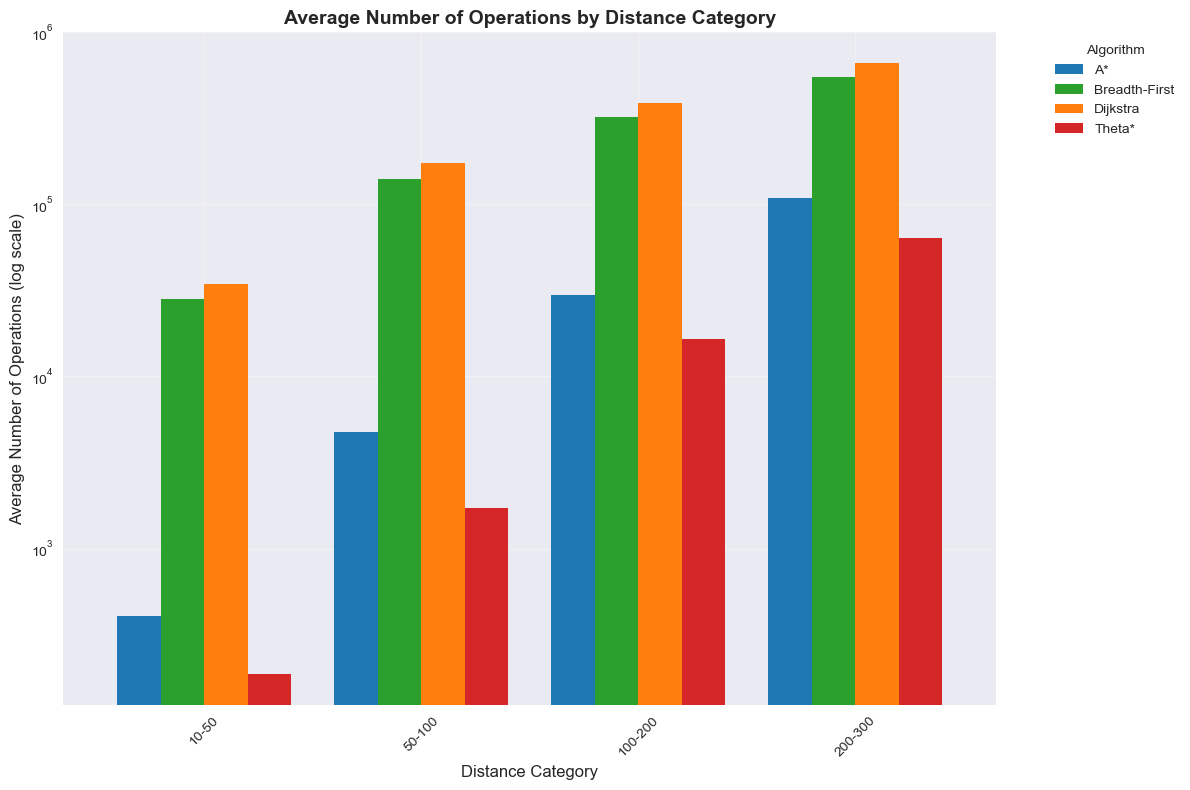

Saved: algorithm_analysis_plots_20250917_203417/04_distance_category_path_length.png


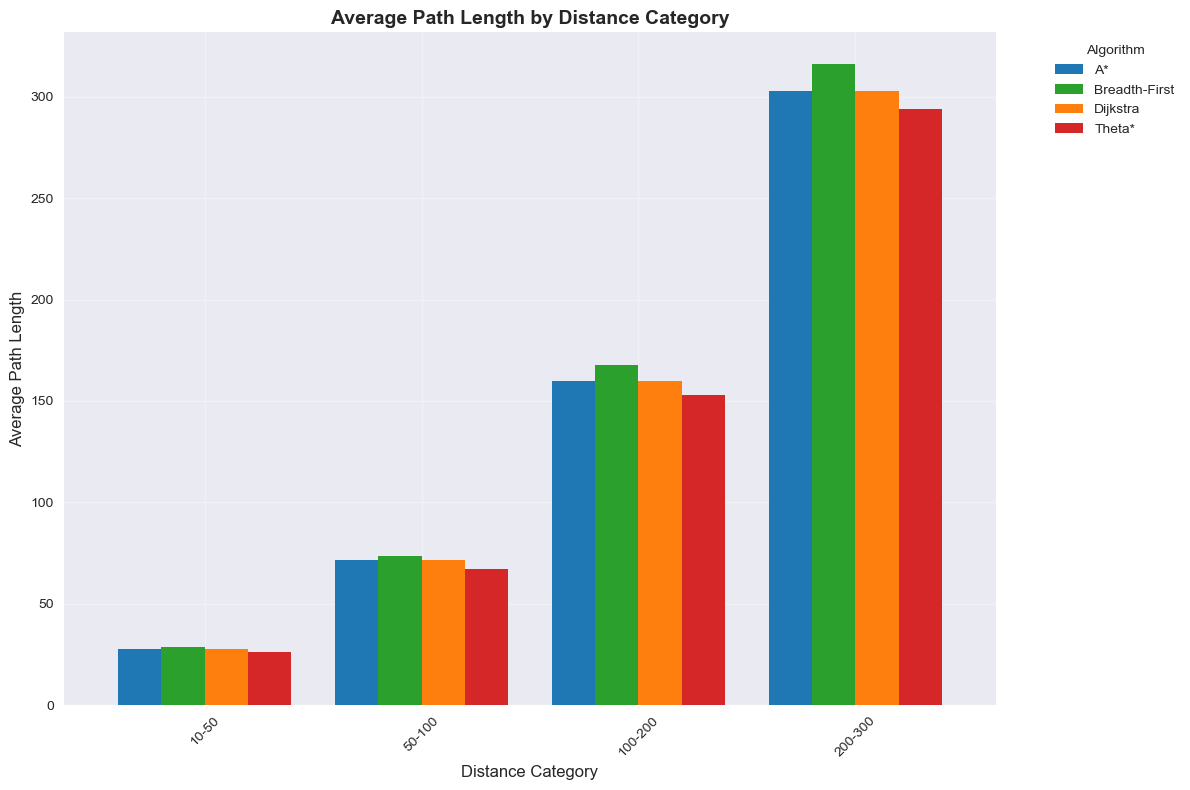

Saved: algorithm_analysis_plots_20250917_203417/04_distance_category_path_efficiency.png


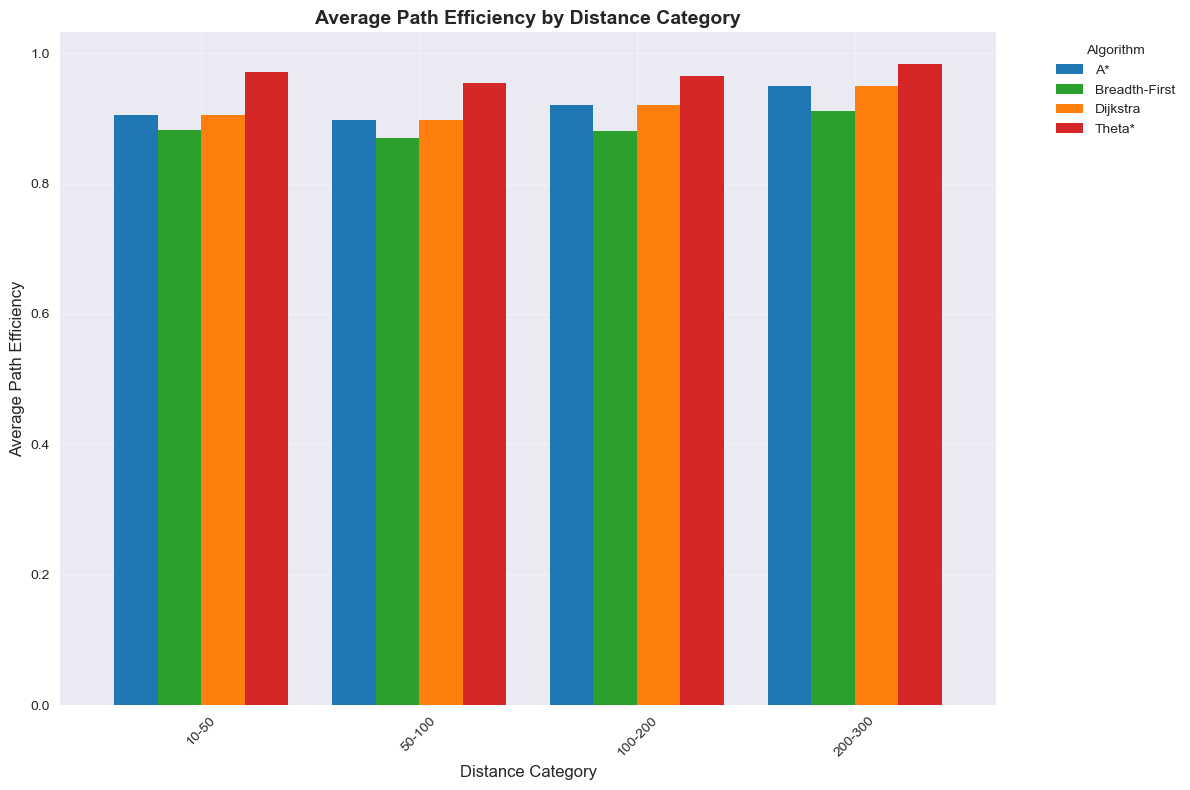

In [65]:
# Generate grouped bar charts for selected metrics by distance category
metrics = ['execution_time', 'operations', 'path_length', 'path_efficiency']
titles = ['Execution Time (s)', 'Number of Operations', 'Path Length', 'Path Efficiency']

for metric, title in zip(metrics, titles):
    # Updated distance categories from CSV
    order = ['10-50', '50-100', '100-200', '200-300']
    ordered = (
        df.assign(distance_category=pd.Categorical(df['distance_category'], categories=order, ordered=True))
          .groupby(['distance_category', 'algorithm'])[metric].mean().unstack(fill_value=0)
          .reindex(order)
    )

    colors = [ALGORITHM_COLORS[algo] for algo in ordered.columns]
    ax = ordered.plot(kind='bar', width=0.8, color=colors)

    plt.title(f'Average {title} by Distance Category', fontsize=14, fontweight='bold')
    plt.xlabel('Distance Category', fontsize=12)

    if metric in ['execution_time', 'operations']:
        ax.set_yscale('log')
        plt.ylabel(f'Average {title} (log scale)', fontsize=12)
    else:
        plt.ylabel(f'Average {title}', fontsize=12)

    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

    filename = f"04_distance_category_{metric}.png"
    save_plot(filename)
    plt.show()

## Statistical Tests and Comparisons


=== INDIVIDUAL ALGORITHM CORRELATION ANALYSIS ===


--- A* Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.748       0.748        0.999
execution_time             0.748           1.000       1.000        0.756
operations                 0.748           1.000       1.000        0.756
path_length                0.999           0.756       0.756        1.000
Saved: algorithm_analysis_plots_20250917_203417/05_correlation_matrix_astar.png


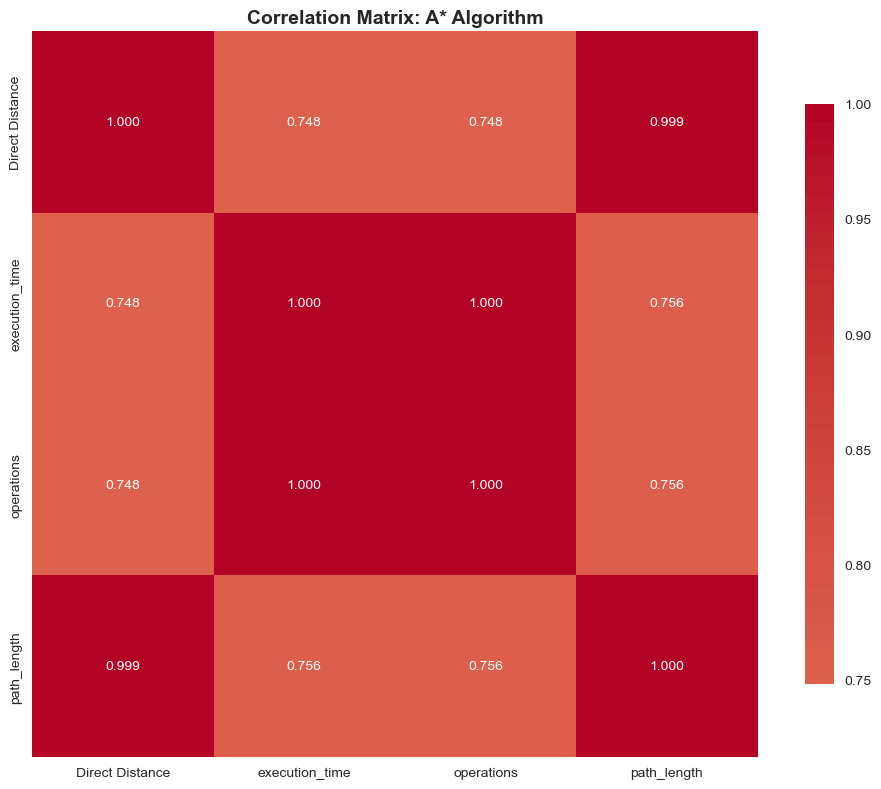


--- Dijkstra Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.979       0.983        0.999
execution_time             0.979           1.000       0.997        0.981
operations                 0.983           0.997       1.000        0.985
path_length                0.999           0.981       0.985        1.000
Saved: algorithm_analysis_plots_20250917_203417/05_correlation_matrix_dijkstra.png


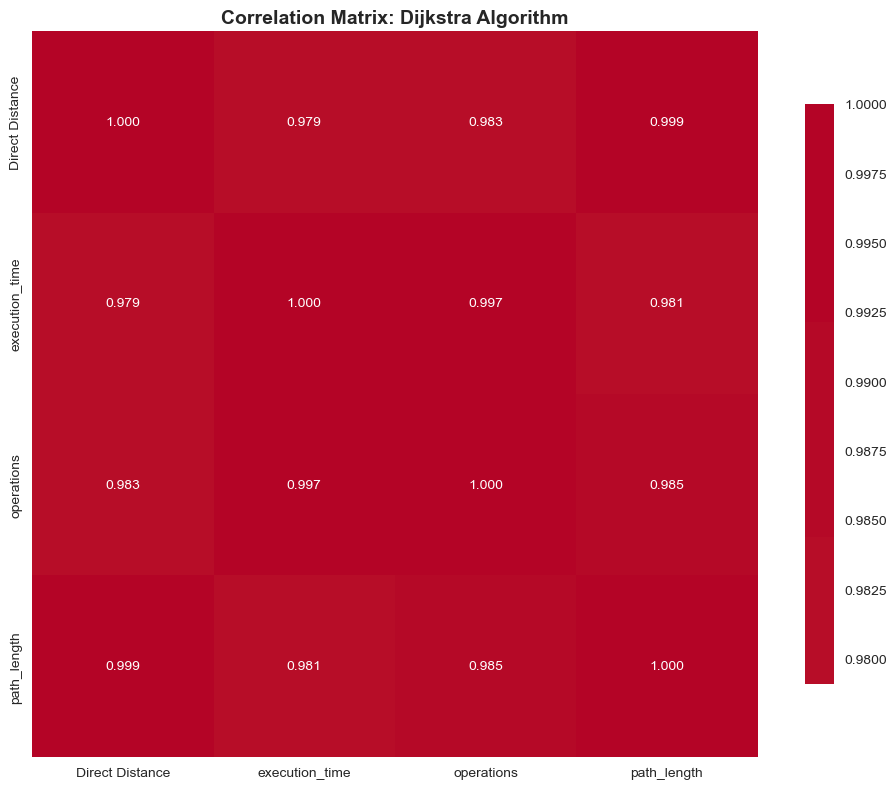


--- Breadth-First Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.983       0.984        0.998
execution_time             0.983           1.000       0.999        0.983
operations                 0.984           0.999       1.000        0.984
path_length                0.998           0.983       0.984        1.000
Saved: algorithm_analysis_plots_20250917_203417/05_correlation_matrix_breadth_first.png


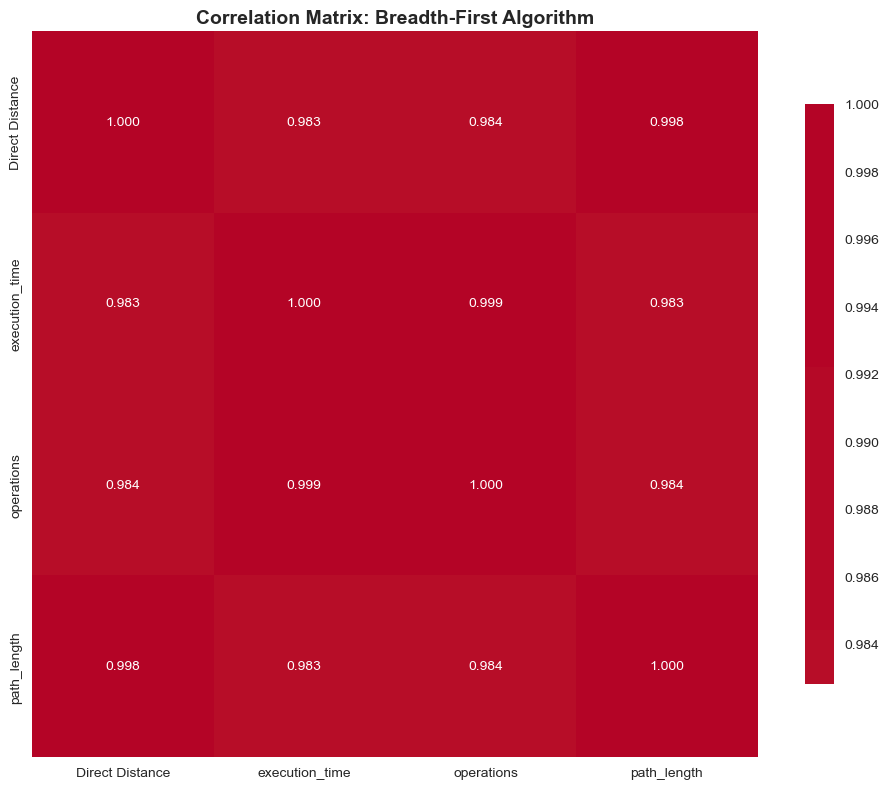


--- Theta* Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.725       0.726        1.000
execution_time             0.725           1.000       0.991        0.728
operations                 0.726           0.991       1.000        0.730
path_length                1.000           0.728       0.730        1.000
Saved: algorithm_analysis_plots_20250917_203417/05_correlation_matrix_thetastar.png


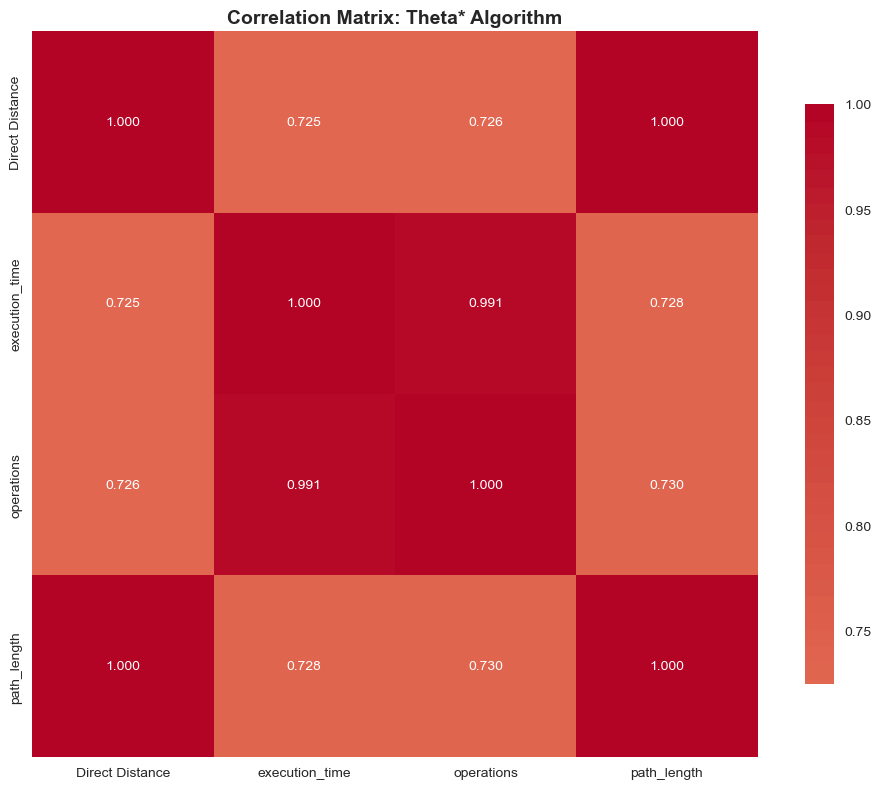

In [66]:
# Individual correlation heatmaps for each algorithm
print("=== INDIVIDUAL ALGORITHM CORRELATION ANALYSIS ===\n")

# Calculate correlation matrix for numerical variables
numerical_vars = ['euclidean_distance', 'execution_time', 'operations', 'path_length']

# Create individual correlation heatmaps for each algorithm
for algorithm in df['algorithm'].unique():
    print(f"\n--- {algorithm} Algorithm ---")
    
    # Get data for this algorithm
    algo_data = df[df['algorithm'] == algorithm][numerical_vars]
    correlation_matrix = algo_data.corr()

    # Rename axis labels for display
    renamed_matrix = correlation_matrix.rename(
        index={'euclidean_distance': 'Direct Distance'},
        columns={'euclidean_distance': 'Direct Distance'}
    )
    
    print("Correlation Matrix:")
    print(renamed_matrix.round(3))
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(renamed_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title(f'Correlation Matrix: {algorithm} Algorithm', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save the plot
    filename = f"05_correlation_matrix_{algorithm.replace('*', 'star').replace('-', '_').lower()}.png"
    save_plot(filename)
    plt.show()

=== INDIVIDUAL ALGORITHM CORRELATION ANALYSIS ===


--- A* Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.748       0.748        0.999
execution_time             0.748           1.000       1.000        0.756
operations                 0.748           1.000       1.000        0.756
path_length                0.999           0.756       0.756        1.000
Saved: algorithm_analysis_plots_20250917_203417/05_correlation_matrix_astar.png


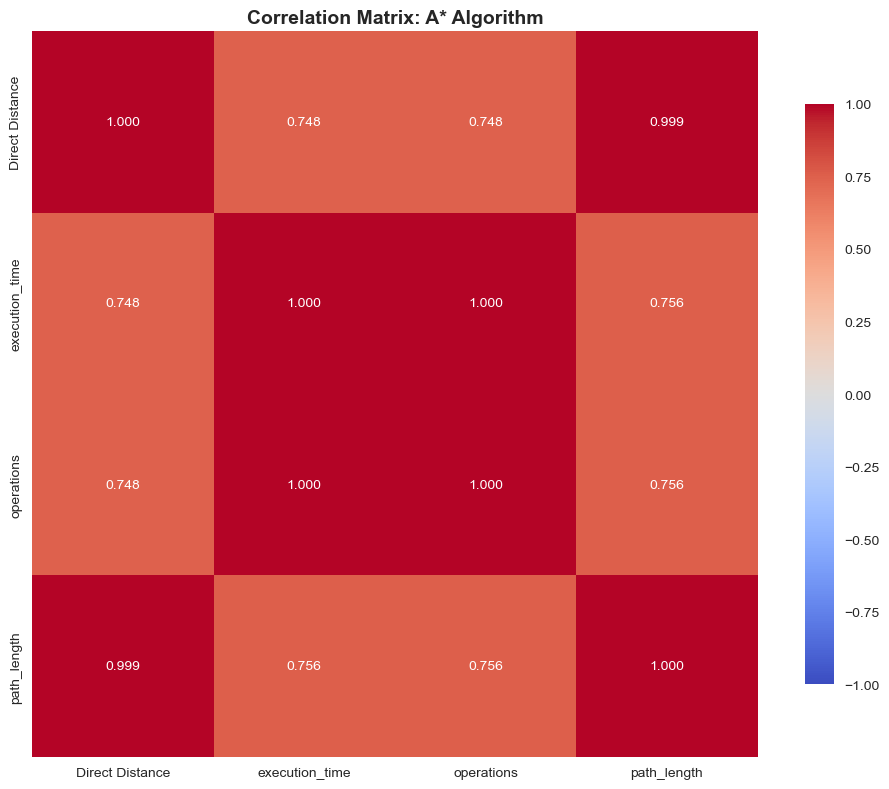


--- Dijkstra Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.979       0.983        0.999
execution_time             0.979           1.000       0.997        0.981
operations                 0.983           0.997       1.000        0.985
path_length                0.999           0.981       0.985        1.000
Saved: algorithm_analysis_plots_20250917_203417/05_correlation_matrix_dijkstra.png


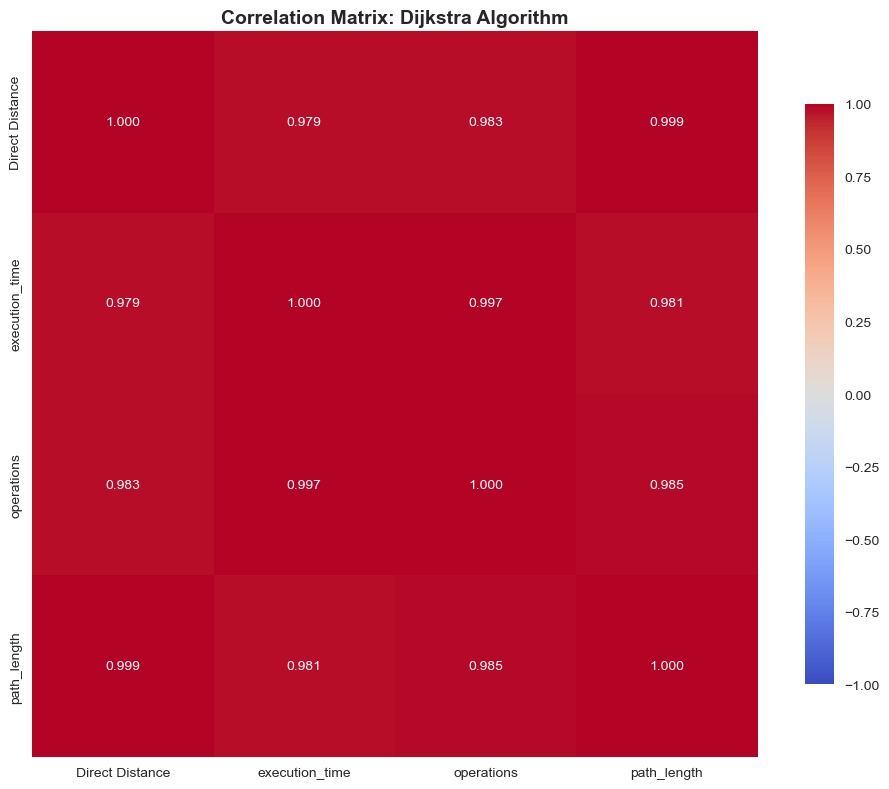


--- Breadth-First Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.983       0.984        0.998
execution_time             0.983           1.000       0.999        0.983
operations                 0.984           0.999       1.000        0.984
path_length                0.998           0.983       0.984        1.000
Saved: algorithm_analysis_plots_20250917_203417/05_correlation_matrix_breadth_first.png


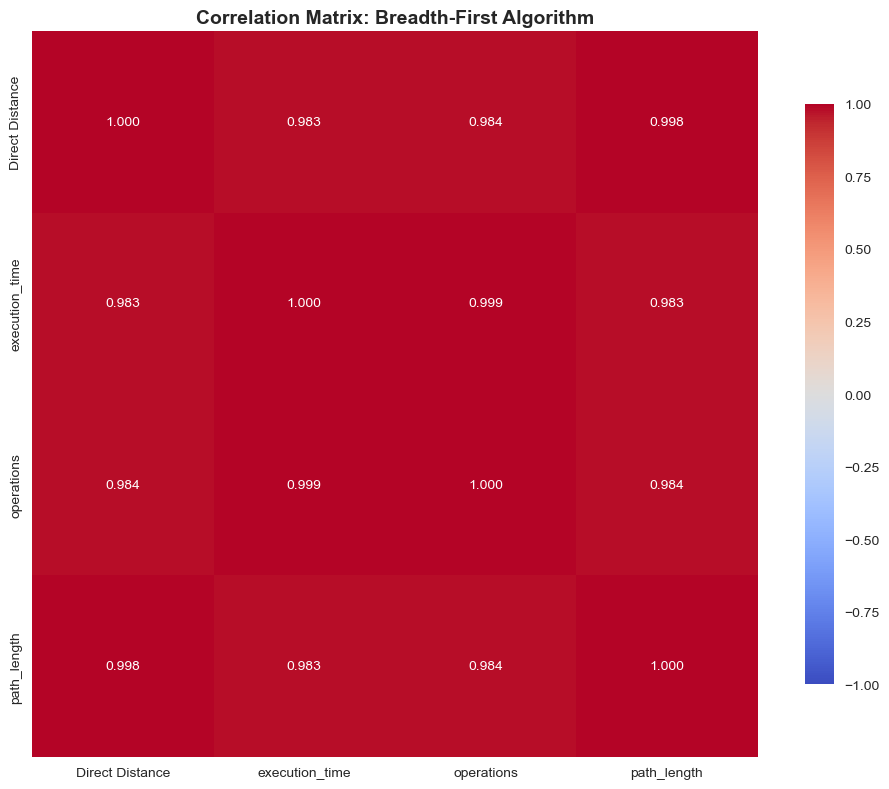


--- Theta* Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.725       0.726        1.000
execution_time             0.725           1.000       0.991        0.728
operations                 0.726           0.991       1.000        0.730
path_length                1.000           0.728       0.730        1.000
Saved: algorithm_analysis_plots_20250917_203417/05_correlation_matrix_thetastar.png


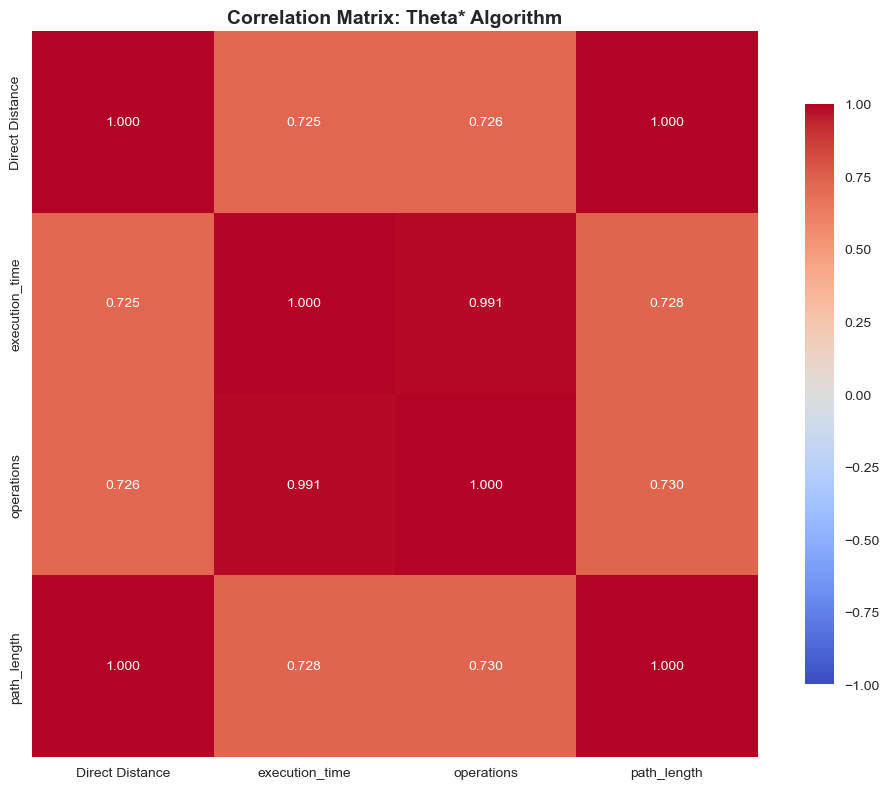

In [67]:
# Individual correlation heatmaps for each algorithm
print("=== INDIVIDUAL ALGORITHM CORRELATION ANALYSIS ===\n")

# Calculate correlation matrix for numerical variables
numerical_vars = ['euclidean_distance', 'execution_time', 'operations', 'path_length']

# Create individual correlation heatmaps for each algorithm
for algorithm in df['algorithm'].unique():
    print(f"\n--- {algorithm} Algorithm ---")
    
    # Get data for this algorithm
    algo_data = df[df['algorithm'] == algorithm][numerical_vars]
    correlation_matrix = algo_data.corr()

    # Rename axis labels for display
    renamed_matrix = correlation_matrix.rename(
        index={'euclidean_distance': 'Direct Distance'},
        columns={'euclidean_distance': 'Direct Distance'}
    )
    
    print("Correlation Matrix:")
    print(renamed_matrix.round(3))
    
    # Create heatmap with fixed color range
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        renamed_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        vmin=-1, vmax=1,      # <-- full correlation range
        square=True,
        fmt='.3f',
        cbar_kws={'shrink': 0.8}
    )
    
    plt.title(f'Correlation Matrix: {algorithm} Algorithm', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save the plot
    filename = f"05_correlation_matrix_{algorithm.replace('*', 'star').replace('-', '_').lower()}.png"
    save_plot(filename)
    plt.show()